In [2]:
import pandas as pd
from mygene import MyGeneInfo
import numpy as np

In [17]:
# Load STRINGDB interactions
string_df = pd.read_csv("/Users/andresgonzalez/Dropbox/Mac/Downloads/9606.protein.links.v12.0.txt", sep=" ", header=0, names=["prot1", "prot2", "score"], dtype={"score": int}, low_memory=False)
string_df["ensp1"] = string_df["prot1"].str.split(".").str[1]
string_df["ensp2"] = string_df["prot2"].str.split(".").str[1]

# Query mygene.info to map ENSP → ENSG
mg = MyGeneInfo()

all_ensps = list(set(string_df["ensp1"]).union(set(string_df["ensp2"])))
query_res = mg.querymany(all_ensps, scopes="ensembl.protein", fields="ensembl.gene", species="human")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSP00000473163', 3)]
434 input query terms found no hit:	['ENSP00000257724', 'ENSP00000364568', 'ENSP00000454322', 'ENSP00000392262', 'ENSP00000498665', 'ENS


In [ ]:

ensp_to_ensg = {}
for entry in query_res:
    if 'notfound' in entry and entry['notfound']:
        continue
    ensp = entry["query"]
    ensembl_field = entry.get("ensembl")
    if isinstance(ensembl_field, dict):
        ensg = ensembl_field.get("gene")
    elif isinstance(ensembl_field, list):
        ensg = ensembl_field[0].get("gene")  # or handle all genes if needed
    else:
        ensg = None
    print(f"{ensp} → {ensg}")
    ensp_to_ensg[ensp] = ensg
print(ensp_to_ensg)

In [49]:
print(string_df["prot1"].head(5))
print(string_df["ensp1"].head(5))

0    9606.ENSP00000000233
1    9606.ENSP00000000233
2    9606.ENSP00000000233
3    9606.ENSP00000000233
4    9606.ENSP00000000233
Name: prot1, dtype: object
0    ENSP00000000233
1    ENSP00000000233
2    ENSP00000000233
3    ENSP00000000233
4    ENSP00000000233
Name: ensp1, dtype: object


In [50]:
# Map proteins to genes
string_df["ensg1"] = string_df["ensp1"].map(ensp_to_ensg)
string_df["ensg2"] = string_df["ensp2"].map(ensp_to_ensg)

# Drop rows where mapping failed
string_df.dropna(subset=["ensg1", "ensg2"], inplace=True)


In [51]:
string_df.head()

,prot1,prot2,score,ensp1,ensp2,ensg1,ensg2
0,9606.ENSP00000000233,9606.ENSP00000356607,173,ENSP00000000233,ENSP00000356607,ENSG00000004059,ENSG00000116191
1,9606.ENSP00000000233,9606.ENSP00000427567,154,ENSP00000000233,ENSP00000427567,ENSG00000004059,ENSG00000137460
2,9606.ENSP00000000233,9606.ENSP00000253413,151,ENSP00000000233,ENSP00000253413,ENSG00000004059,ENSG00000131100
3,9606.ENSP00000000233,9606.ENSP00000493357,471,ENSP00000000233,ENSP00000493357,ENSG00000004059,ENSG00000105443
4,9606.ENSP00000000233,9606.ENSP00000324127,201,ENSP00000000233,ENSP00000324127,ENSG00000004059,ENSG00000156011


In [52]:
# Sort gene pairs to avoid duplicate edges in reverse
string_df[["ensg1", "ensg2"]] = pd.DataFrame(
    np.sort(string_df[["ensg1", "ensg2"]].values, axis=1), index=string_df.index
)

# Drop duplicate edges (same gene pair)
string_collapsed = string_df.drop_duplicates(subset=["ensg1", "ensg2"])



In [53]:
# Save output as space-separated TXT file
string_collapsed[["ensg1", "ensg2", "score"]].to_csv("/Users/andresgonzalez/Dropbox/Mac/Downloads/9606.protein.links.v12.0_asENSG.txt", sep=" ", index=False, header=False)

In [55]:
string_collapsed.head()

,prot1,prot2,score,ensp1,ensp2,ensg1,ensg2
0,9606.ENSP00000000233,9606.ENSP00000356607,173,ENSP00000000233,ENSP00000356607,ENSG00000004059,ENSG00000116191
1,9606.ENSP00000000233,9606.ENSP00000427567,154,ENSP00000000233,ENSP00000427567,ENSG00000004059,ENSG00000137460
2,9606.ENSP00000000233,9606.ENSP00000253413,151,ENSP00000000233,ENSP00000253413,ENSG00000004059,ENSG00000131100
3,9606.ENSP00000000233,9606.ENSP00000493357,471,ENSP00000000233,ENSP00000493357,ENSG00000004059,ENSG00000105443
4,9606.ENSP00000000233,9606.ENSP00000324127,201,ENSP00000000233,ENSP00000324127,ENSG00000004059,ENSG00000156011


In [59]:
# Filter interactions based on confidence score and save the file
input_file = "/Users/andresgonzalez/Dropbox/Mac/Downloads/9606.protein.links.v12.0_asENSG.txt"
output_file = "/Users/andresgonzalez/Dropbox/Mac/Downloads/9606.protein.links.v12.0_asENSG_confidenceFilterd.txt"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        parts = line.strip().split()
        if len(parts) == 3:
            try:
                score = int(parts[2])
                if score >= 700:
                    outfile.write(line)
            except ValueError:
                # Skip lines with invalid score
                continue

In [ ]:
# Load the lnctard dataset (tab-separated)
df = pd.read_csv("/Users/andresgonzalez/Dropbox/Mac/Downloads/lnctard2.0.txt", sep="\t", dtype=str, encoding="latin1")

# Filter rows where the Drugs column is 'NA' to make sure that the interaction is not drug-related
filtered = df[df["Drugs"].isna()]
filtered["Drugs"]

In [72]:
# Keep only the required columns
selected = filtered[["RegulatorEnsembleID", "TargetEnsembleID", "diseaseCategory","DiseaseName2"]]

selected


,RegulatorEnsembleID,TargetEnsembleID,diseaseCategory,DiseaseName2
0,ENSG00000185186,NaN,Cancer,Thyroid cancer
1,ENSG00000203499,ENSG00000124762,Cancer,Brain glioma
2,ENSG00000245532,ENSG00000105329,Cancer,Liver cancer
3,ENSG00000245532,ENSG00000148516,Cancer,Breast cancer
4,ENSG00000251003,ENSG00000240972,Cancer,Gastric cancer
...,...,...,...,...
8355,ENSG00000203499,ENSG00000116604,Cancer,Liver cancer
8356,ENSG00000237894,NaN,Cancer,Oral cavity cancer
8357,ENSG00000249859,ENSG00000111206,Cancer,Malignant mesothelioma
8358,NaN,ENSG00000233006,Cancer,Gastric cancer


In [73]:
# Get rid of NA values in the selected columns
cleaned = selected.dropna()

In [76]:
# Save the cleaned DataFrame to a new file
cleaned.to_csv("/Users/andresgonzalez/Dropbox/Mac/Downloads/lnctard2.0_filtered.txt", sep="\t", index=False)

In [77]:
# Load STRINGDB PPI
string_df = pd.read_csv('/Users/andresgonzalez/Dropbox/Mac/Downloads/9606.protein.links.v12.0_asENSG_confidenceFilterd.txt', sep=' ', header=None, names=['Protein1', 'Protein2', 'Score'])

# Load lncTarD
lnctard_df = pd.read_csv('/Users/andresgonzalez/Dropbox/Mac/Downloads/lnctard2.0_filtered.txt', sep='\t')

In [78]:
string_df.head()

,Protein1,Protein2,Score
0,ENSG00000004059,ENSG00000072818,825
1,ENSG00000004059,ENSG00000122218,718
2,ENSG00000004059,ENSG00000275338,952
3,ENSG00000004059,ENSG00000184432,752
4,ENSG00000004059,ENSG00000105669,795


In [79]:
lnctard_df.head()

,RegulatorEnsembleID,TargetEnsembleID,diseaseCategory,DiseaseName2
0,ENSG00000203499,ENSG00000124762,Cancer,Brain glioma
1,ENSG00000245532,ENSG00000105329,Cancer,Liver cancer
2,ENSG00000245532,ENSG00000148516,Cancer,Breast cancer
3,ENSG00000251003,ENSG00000240972,Cancer,Gastric cancer
4,ENSG00000255717,ENSG00000131203,Cancer,Breast cancer


In [84]:
#Check how many unique diseases are in the lncTarD dataset
len(lnctard_df['DiseaseName2'].unique())

197

In [ ]:
subtype_groups = lnctard_df.groupby('DiseaseName2')
subtype_groups.head()

In [94]:
import networkx as nx

graphs = []
labels = []
# Create a mapping from disease categories to numerical labels
label_map = {label: idx for idx, label in enumerate(lnctard_df['diseaseCategory'].unique())}

In [95]:
label_map

{'Cancer': 0,
 'Gastrointestinal system disease': 1,
 'Cardiovascular system disease': 2,
 'Respiratory system disease': 3,
 'Endocrine system disease': 4,
 'Reproductive system disease': 5,
 'Immune system disease': 6,
 'Nervous system disease': 7,
 'Musculoskeletal system disease': 8,
 'Urinary system disease': 9,
 'Disease of metabolism': 10,
 'Syndrome': 11,
 'Other': 12,
 'Integumentary system disease': 13,
 'Disease by infectious agent': 14,
 'Genetic disease': 15,
 'Disease of mental health': 16}

In [97]:
from tqdm import tqdm

for subtype, group in tqdm(subtype_groups):
    # Start with a base graph with STRING edges
    G = nx.Graph()
    
    # Add STRING protein-protein interactions
    for _, row in string_df.iterrows():
        G.add_edge(row['Protein1'], row['Protein2'])

    # Add lncRNA-protein edges for this subtype
    for _, row in group.iterrows():
        G.add_edge(row['RegulatorEnsembleID'], row['TargetEnsembleID'])
    
    # Save graph and label
    graphs.append(G)
    labels.append(label_map[group['diseaseCategory'].iloc[0]])

python(46332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 197/197 [12:02<00:00,  3.67s/it]


In [99]:
len(labels)

197

In [100]:
len(graphs)

197

In [111]:
len(graphs[38].edges())

229721

In [ ]:
len(graphs[38].nodes())

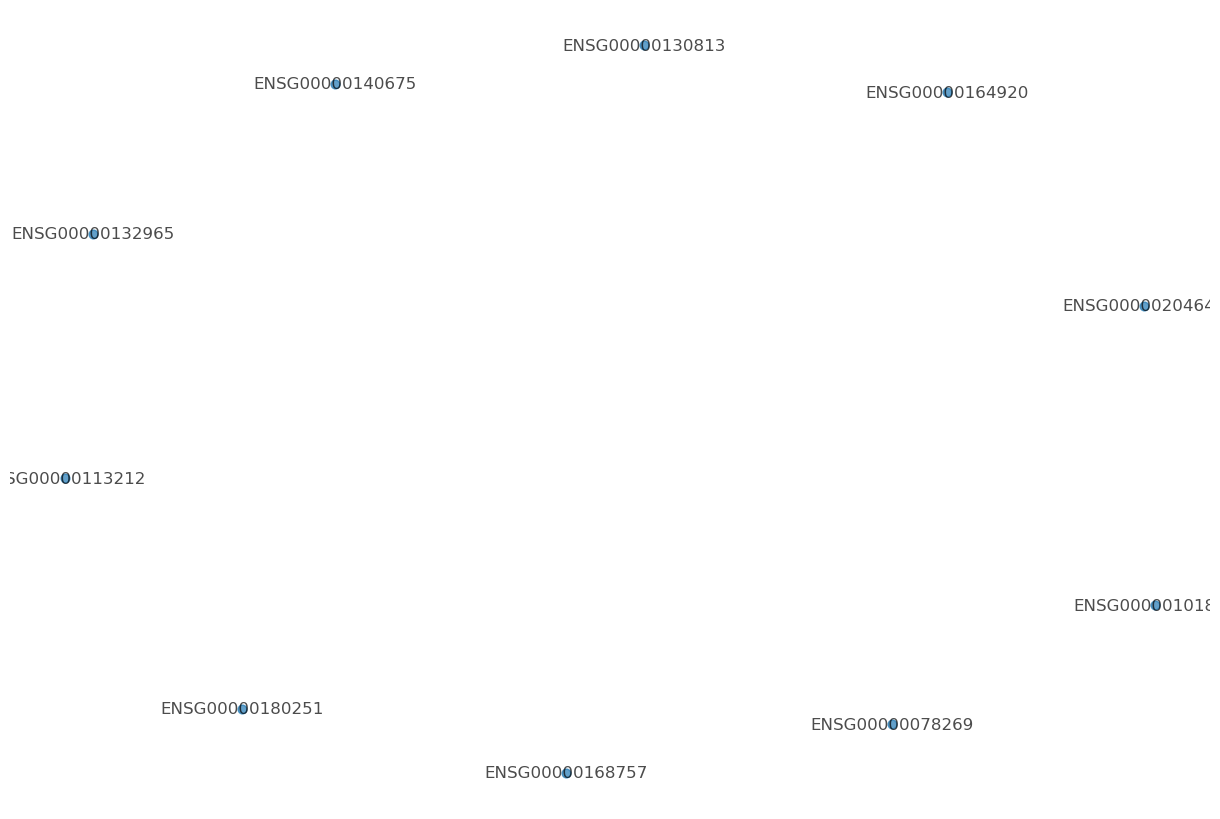

In [129]:
import matplotlib.pyplot as plt
import random

# Sample nodes (e.g., 5000 random nodes)
sample_nodes = random.sample(list(graphs[38].nodes()), 10)
subgraph = graphs[38].subgraph(sample_nodes)

plt.figure(figsize=(12, 8))
nx.draw(subgraph, node_size=40, with_labels=True, alpha=0.7)
plt.show()

In [123]:
sum(connectivity) / float(len(connectivity))

124.77157360406092

In [124]:
label_map

{'Cancer': 0,
 'Gastrointestinal system disease': 1,
 'Cardiovascular system disease': 2,
 'Respiratory system disease': 3,
 'Endocrine system disease': 4,
 'Reproductive system disease': 5,
 'Immune system disease': 6,
 'Nervous system disease': 7,
 'Musculoskeletal system disease': 8,
 'Urinary system disease': 9,
 'Disease of metabolism': 10,
 'Syndrome': 11,
 'Other': 12,
 'Integumentary system disease': 13,
 'Disease by infectious agent': 14,
 'Genetic disease': 15,
 'Disease of mental health': 16}

In [126]:
from collections import Counter
frequency = Counter(labels)

print("Number frequencies:")
for num, count in frequency.items():
    print(f"Number {num}: {count} times")

Number frequencies:
Number 12: 32 times
Number 0: 70 times
Number 7: 13 times
Number 6: 6 times
Number 2: 22 times
Number 8: 9 times
Number 3: 6 times
Number 14: 6 times
Number 1: 13 times
Number 16: 1 times
Number 9: 3 times
Number 10: 3 times
Number 5: 6 times
Number 4: 3 times
Number 15: 1 times
Number 11: 2 times
Number 13: 1 times


In [153]:
cc38=sorted(nx.connected_components(graphs[38]))

In [155]:
S38=[G.subgraph(c).copy() for c in cc38]

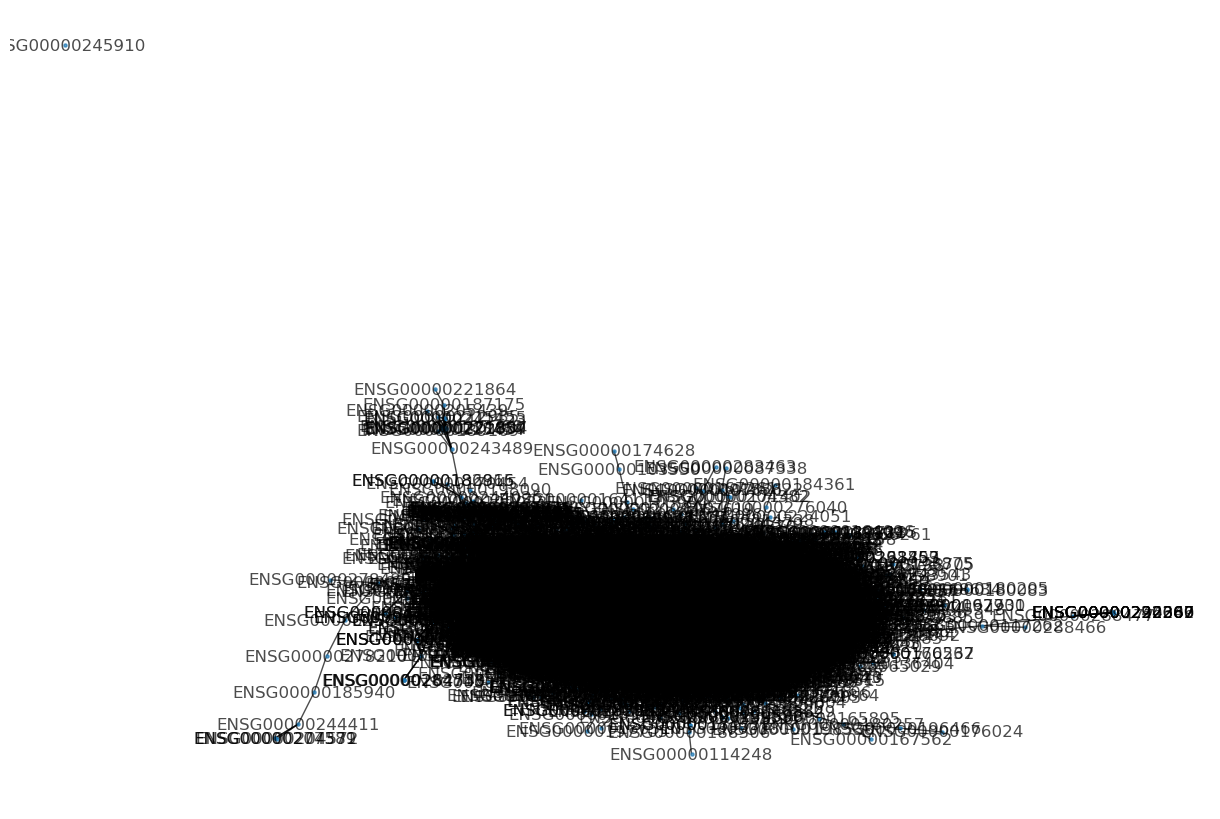

In [166]:
plt.figure(figsize=(12, 8))
nx.draw(S38[0], node_size=5, with_labels=True, alpha=0.7)
plt.show()

In [165]:
S38[25].nodes()

NodeView(('ENSG00000204524', 'ENSG00000083844'))

In [216]:
import networkx as nx
import pickle

# Save list of graphs
with open("/Users/andresgonzalez/Dropbox/Mac/Downloads/graphs.pkl", "wb") as f:
    pickle.dump(graphs, f)

In [221]:
label_map_inv={v: k for k, v in label_map.items()}

In [222]:
label_map_inv

{0: 'Cancer',
 1: 'Gastrointestinal system disease',
 2: 'Cardiovascular system disease',
 3: 'Respiratory system disease',
 4: 'Endocrine system disease',
 5: 'Reproductive system disease',
 6: 'Immune system disease',
 7: 'Nervous system disease',
 8: 'Musculoskeletal system disease',
 9: 'Urinary system disease',
 10: 'Disease of metabolism',
 11: 'Syndrome',
 12: 'Other',
 13: 'Integumentary system disease',
 14: 'Disease by infectious agent',
 15: 'Genetic disease',
 16: 'Disease of mental health'}

In [224]:
for i, G in tqdm(enumerate(graphs)):
    disease_index=labels[i]
    disease=label_map_inv[disease_index]
    root="/Users/andresgonzalez/Dropbox/Mac/Downloads/"
    nx.write_graphml(G, f"{root}graph_{i}_{disease}.graphml")

197it [05:13,  1.59s/it]


In [226]:
import pickle

with open('Users/andresgonzalez/Dropbox/Mac/Downloads/label_list_in_order.pkl', 'wb') as fp:
    pickle.dump(labels, fp)

In [227]:
with open('Users/andresgonzalez/Dropbox/Mac/Downloads/label_dictionary.pkl', 'wb') as fp:
    pickle.dump(label_map, fp)

In [3]:
import pickle
# Load the list of graphs
with open("/Users/andresgonzalez/Desktop/mlrg/graphs.pkl", "rb") as f:
    loaded_graphs = pickle.load(f)

In [11]:
G=loaded_graphs[38]
# Graph metrics
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())

components = list(nx.connected_components(G))
print("Connected components:", len(components))
print("Largest component size:", len(max(components, key=len)))

avg_deg = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", round(avg_deg, 2))
print("Density:", round(nx.density(G), 4))
print("\nTop 10 high-degree nodes:")


top_nodes = sorted(loaded_graphs[38].degree(), key=lambda x: x[1], reverse=True)[:10]
for node, degree in top_nodes:
    print(f"{node}: {degree}")

Total nodes: 15875
Total edges: 229721
Connected components: 125
Largest component size: 15558
Average degree: 28.94
Density: 0.0018

Top 10 high-degree nodes:
ENSG00000141510: 757
ENSG00000143947: 579
ENSG00000221983: 511
ENSG00000146648: 493
ENSG00000168036: 458
ENSG00000274618: 446
ENSG00000183598: 444
ENSG00000075624: 433
ENSG00000142208: 428
ENSG00000149806: 412


In [16]:
import mygene

mg = mygene.MyGeneInfo()

# ENSG ID to alias
for node, degre in top_nodes:
    print(f"Node: {node}, Degree: {degree}")
    # Query gene symbol for each ENSG ID
    result = mg.query(node, scopes='ensembl.gene', fields='symbol,name', species='human')
    gene_symbol = result['hits'][0]['symbol']
    print(f"{node} → {gene_symbol}")

Input sequence provided is already in string format. No operation performed


Node: ENSG00000141510, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000141510 → TP53
Node: ENSG00000143947, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000143947 → RPS27A
Node: ENSG00000221983, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000221983 → UBA52
Node: ENSG00000146648, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000146648 → EGFR
Node: ENSG00000168036, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000168036 → CTNNB1
Node: ENSG00000274618, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000274618 → H4C6
Node: ENSG00000183598, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000183598 → H3C13
Node: ENSG00000075624, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000075624 → ACTB
Node: ENSG00000142208, Degree: 412


Input sequence provided is already in string format. No operation performed


ENSG00000142208 → AKT1
Node: ENSG00000149806, Degree: 412
ENSG00000149806 → FAU


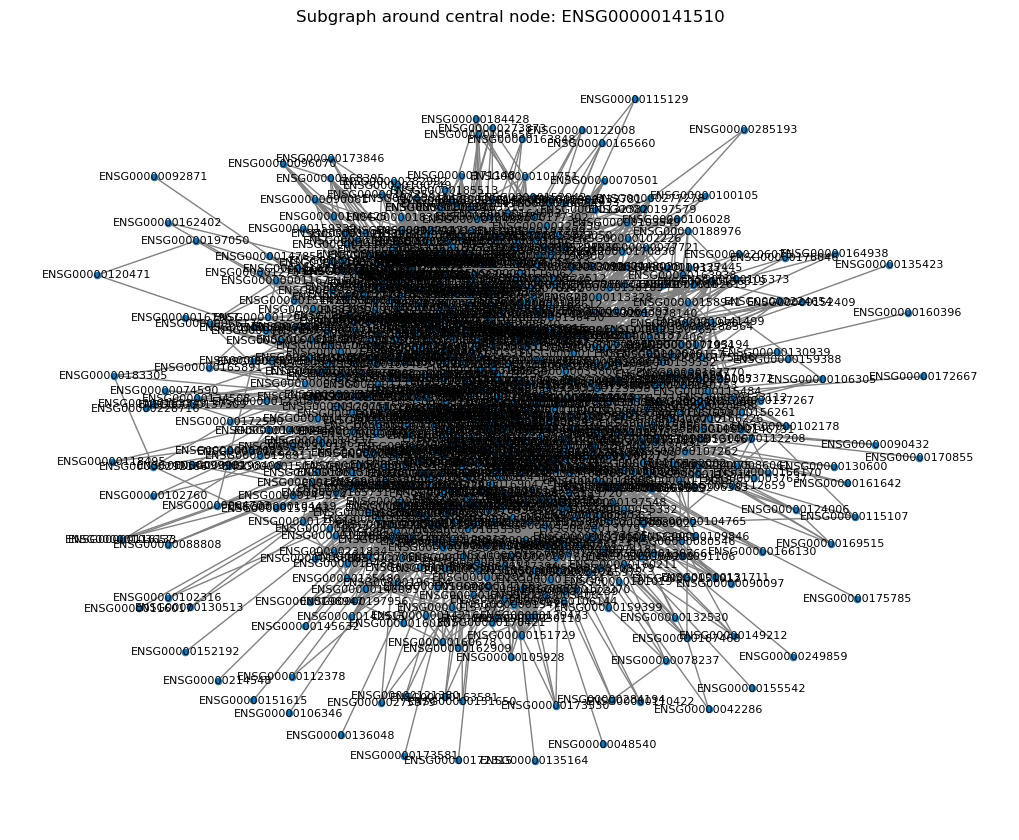

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
central_node = "ENSG00000141510"

# Get all nodes directly connected to the central node (its neighbors)
neighbors = list(loaded_graphs[38].neighbors(central_node))

# Include the central node itself
sub_nodes = [central_node] + neighbors

# Create the subgraph based on selected nodes
subgraph = loaded_graphs[38].subgraph(sub_nodes)


plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(
    subgraph, pos,
    with_labels=True,
    node_size=20,
    font_size=8,
    edge_color='gray'
)
plt.title(f"Subgraph around central node: {central_node}")
plt.show()

In [10]:
root="/Users/andresgonzalez/Dropbox/Mac/Downloads/"
nx.write_graphml(subgraph, f"{root}subgraph_{central_node}.graphml")